## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch as t
from chromatography import placement_error, overlap_error, ExperimentAnalytes
%matplotlib inline

## Dataset Import

In [20]:
alist = pd.read_csv('../data/Peter32.csv')

## Useful functions definition

In [72]:
run = ExperimentAnalytes(k0 = alist.k0.values, S = alist.S.values, h=0.001, grad='iso', run_time=None)
phis = [0.12, 0.2, 0.3, 0.09, 0.21]
for phi in phis:
    if phi == 0.21:
        run.step(phi, 30)
    else:
        run.step(phi, 1.)


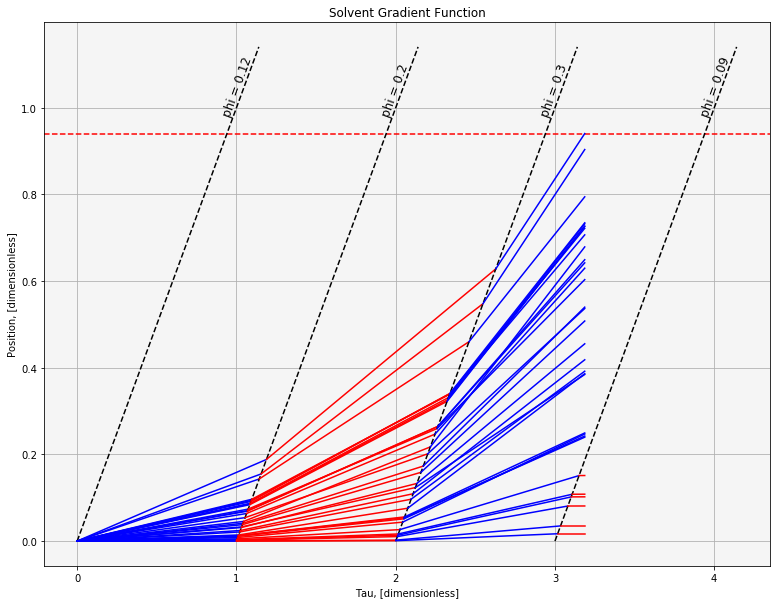

In [74]:
run.print_analytes(angle=70, rc=(13, 10))

In [37]:
list(np.sort(run.positions[-1]))

[0.10857808084919225,
 0.18866184203619452,
 0.23303111441231691,
 0.2591787068875356,
 0.27109625895383416,
 0.3003789967634487,
 0.3670595083293517,
 0.3813705396758685,
 0.3851406277198019,
 0.43447354174207303,
 0.44271240457112787,
 0.5313435642643025,
 0.5446869036200848,
 0.5515568023635063,
 0.5534557429748306,
 0.5691298843357553,
 0.5838535029418276,
 0.5863280767070995,
 0.6113248413947604,
 0.6278022183705475,
 0.6302787603545692,
 0.6317618021056319,
 0.6341890022769862,
 0.6399240629137724,
 0.6560481284411288,
 0.6761476375250876,
 0.6818825441684966,
 0.684367649278863,
 0.6861268719608554,
 0.7269097153368346,
 0.7393090150323731,
 0.7445294714912305]

In [38]:
def sig(height, mu):
    return np.sqrt((mu**2) * height)

In [39]:
def k(k0, S, phi):
    return (10 ** (-phi * S)) * k0

In [40]:
def xk(k0, S, phi, dt):
    return dt /(k(k0, S, phi) + 1)

In [55]:
def iso_list(anlist, phi):
    k0 = anlist[:,0]
    S = anlist[:,1]
    dt =  (1 - 2 * np.sqrt(0.001))
    return np.sort(dt /((10 ** (-phi * S)) * k0 + 1))

In [42]:
def iso_spot(anlist, phi):
    return pl_error(iso_list(anlist, phi))

In [43]:
def int_(ud, sigd, ua, siga):
    return (2 * siga ** 2 * sigd - 2 * siga * sigd ** 2 \
            + sigd ** 2 * ua + siga ** 2 * ud)\
            / ( siga ** 2 + sigd ** 2)

In [44]:
def bl(ud, sigd, ua, siga):
    first = int_(ud, sigd, ua, siga)
    second = ua - 2 * siga
    return np.stack([first,second], axis=1).max(axis=1)

In [45]:
def bu(ud, sigd, ua, siga):
    first = int_(ud, sigd, ua, siga)
    second = ud + 2 * sigd
    return np.stack([first,second], axis=1).min(axis=1)

In [46]:
def cushlist(res_list):
    return np.concatenate([ np.array([
        0, 10 ** -10]).reshape(1, -1),
        res_list,
        np.array([1, 10 ** -10]).reshape(1, -1)])

In [47]:
def poi(res_list):
    return np.stack(
        [
            bl(res_list[:-2, 0], res_list[:-2, 1], res_list[1:-1, 0], res_list[1:-1, 1]),
            res_list[1:-1, 0],
            bu(res_list[1:-1, 0], res_list[1:-1, 1], res_list[2:, 0], res_list[2:, 1])
        ],
        axis=1
       )

In [48]:
def yval(x_list, chrom):

    denominator = 4 * chrom[:, 1] ** 2
    temp_1 = np.abs(x_list[:, 0] - x_list[:, 1])
    temp_1[temp_1 > chrom[:, 1]] = 0
    temp_1 /= denominator
    
    temp_2 = 1/(2 * chrom[:, 1])
    
    temp_3 = np.abs(x_list[:, 1] - x_list[:, 1])
    temp_3[np.abs(x_list[:, 2] - x_list[:, 1]) > chrom[:, 1]] = 0
    temp_3 /= denominator
    
    return np.stack([temp_1, temp_2, temp_3], axis=1)


In [49]:
def narea(main_list, x_list, y_list):
    return 1 - ((y_list[:, 1] - y_list[:, 0])*(x_list[:, 1] - x_list[:, 0])
            - (y_list[:, 2] - y_list[:, 1])*(x_list[:, 2] - x_list[:, 1])).sum()/(2 * main_list.shape[0])

In [50]:
def lfn(main_list, x_list, y_list):
    return plerror(main_list) + narea(main_list, x_list, y_list)

In [51]:
def isoloss(alist, phi, h):
    chroma = iso_list(alist.values, phi)
    chroma = np.array([chroma, sig(h, chroma)]).T
    schroma = chroma[chroma[:,0].argsort()]
    padlist = cushlist(schroma)
    npoi = poi(padlist)
    ypoi = yval(npoi, schroma)
    lofn = placement_error(schroma[:,0]) + narea(schroma,npoi, ypoi)
    
    return chroma, schroma, narea(schroma,npoi, ypoi)

In [52]:
def my_isoloss(alist, phi, h):
    chroma = iso_list(alist.values, phi)
    chroma = np.array([chroma, sig(h, chroma)]).T
    schroma = chroma[chroma[:,0].argsort()]
    lofn = placement_error(schroma[:,0]) + overlap_error(schroma[:,0], schroma[:,1])
    
    return chroma, schroma, lofn

In [56]:
%timeit  isoloss(alist, 0.37, 0.001)

225 µs ± 5.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [57]:
%timeit  my_isoloss(alist, 0.34, 0.001)

159 µs ± 5.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
a1, a2, a3 = isoloss(alist, 0.37, 0.001) 
b1, b2, b3 = my_isoloss(alist, 0.37, 0.001) 